In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader, Subset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score,roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

import os
import os.path as op
from glob import glob
from pathlib import Path
from tqdm.auto import tqdm

In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    #transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),  # Randomly rotate the images by 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, etc.
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
dataset = ImageFolder(root='Pistachio_Image_Dataset', transform=transform)
len(dataset)

2148

In [4]:
torch.manual_seed(42)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [5]:
# Get the class to index mapping
# class_names = dataset.classes

# def list_all_samples(dataset):
#     for i in range(len(dataset)):
#         img, label = dataset[i]
#         img_path = dataset.dataset.samples[dataset.indices[i]][0]  # Get the original file path
#         print(f"Image Path: {img_path}, Label: {class_names[label]}")

# print("Training Dataset:")
# list_all_samples(train_dataset)

# print("\nValidation Dataset:")
# list_all_samples(val_dataset)

# print("\nTest Dataset:")
# list_all_samples(test_dataset)


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 64x64--> 32x32
        # print(f"Shape after conv1 and pool: {x.shape}")
        x = self.pool(F.relu(self.conv2(x))) # 32x32 --> 16x16
        # print(f"Shape after conv2 and pool: {x.shape}")
        x = self.pool(F.relu(self.conv3(x))) # 16x16 --> 8x8
        # print(f"Shape after conv3 and pool: {x.shape}")

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

In [8]:
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader, lambda_L1 = 0.0):
    training_logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss, correct = 0, 0
        for X, y in train_loader:
            y = y.float().view(-1,1)
            y_pred = model(X)
            loss = loss_function(y_pred, y)

            L1_loss = 0.0
            for p in model.parameters():
                L1_loss = L1_loss + p.abs().sum()

            loss = loss + lambda_L1 * L1_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            #correct += (y_pred.round() == y).sum().item()
            correct += ((y_pred > 0.55).float() == y).sum().item()
        print('-'*80)
        training_logs['train_loss'].append(train_loss / len(train_loader))
        training_logs['train_acc'].append(correct / len(train_loader.dataset))

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in validation_loader:
                y = y.float().view(-1,1)
                y_pred = model(X)
                val_loss += loss_function(y_pred, y).item()
                #correct += (y_pred.round() == y).sum().item()
                correct += ((y_pred > 0.55).float() == y).sum().item()
        
        training_logs['val_loss'].append(val_loss / len(validation_loader))
        training_logs['val_acc'].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10),
              f"train loss: {training_logs['train_loss'][-1]:.5f}",
              f"train acc: {training_logs['train_acc'][-1]:.5f}",

              f"val loss: {training_logs['val_loss'][-1]:.5f}",
              f"val acc: {training_logs['val_acc'][-1]:.5f}",
              )
        #print('-'*80)
    return model, training_logs

In [9]:
model = Model()

In [10]:
n_epoch = 100
loss_fn = nn.BCELoss()

weight_decay = 0.001
lambda_L1 = 0.0001
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
net, net_history = train(model, n_epoch, loss_fn, optimizer, train_dataloader, test_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Epochs 0   train loss: 0.61658 train acc: 0.64271 val loss: 0.56293 val acc: 0.70279
--------------------------------------------------------------------------------
Epochs 1   train loss: 0.49228 train acc: 0.77977 val loss: 0.40042 val acc: 0.83282
--------------------------------------------------------------------------------
Epochs 2   train loss: 0.45365 train acc: 0.78975 val loss: 0.38190 val acc: 0.84830
--------------------------------------------------------------------------------
Epochs 3   train loss: 0.42621 train acc: 0.81238 val loss: 0.34900 val acc: 0.84520
--------------------------------------------------------------------------------
Epochs 4   train loss: 0.41144 train acc: 0.81836 val loss: 0.37203 val acc: 0.84211
--------------------------------------------------------------------------------
Epochs 5   train loss: 0.40167 train acc: 0.83234 val loss: 0.44600 val acc: 0.80495
----

In [11]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

C:\MinGW\ipykernel_11752\4036892942.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


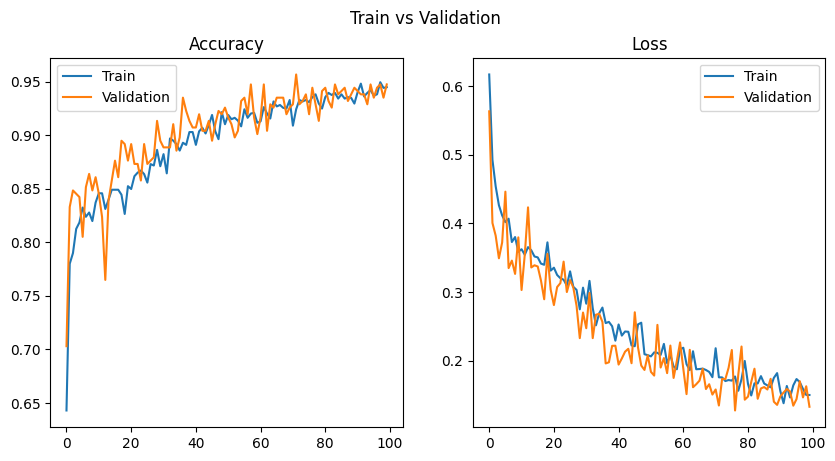

In [12]:
plot_graph(net_history)

In [13]:
def evaluate_model(model, train_dataloader, test_dataloader, loss_list):
    model.eval()  # Explicitly set to evaluation mode

    # Initialize lists to store true labels and predictions for train and test datasets
    y_test_true = []
    y_test_prob = []
    Y_train_true = []
    Y_train_prob = []

    # Collect predictions and true labels from the test dataloader
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            y_prob = model(X_batch).squeeze()
            y_test_prob.extend(y_prob.detach().cpu().numpy())
            y_test_true.extend(y_batch.cpu().numpy())

    # Collect predictions and true labels from the train dataloader
        for X_batch, y_batch in train_dataloader:
            y_prob = model(X_batch).squeeze()
            Y_train_prob.extend(y_prob.detach().cpu().numpy())
            Y_train_true.extend(y_batch.cpu().numpy())

    # Convert lists to numpy arrays
    y_test_prob = np.array(y_test_prob)
    y_test_true = np.array(y_test_true)
    Y_train_prob = np.array(Y_train_prob)
    Y_train_true = np.array(Y_train_true)

    # Calculate binary predictions based on probability thresholds
    y_test_pred = np.where(y_test_prob > 0.55, 1, 0)
    Y_train_pred = np.where(Y_train_prob > 0.55, 1, 0)

    # Plot the loss curve and ROC curve
    plt.figure(figsize=(20, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(loss_list)
    plt.title('Loss across epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')

    # ROC Curve
    plt.subplot(1, 2, 2)

    # ROC Curve for Test/Validation
    fpr_v, tpr_v, _ = roc_curve(y_test_true, y_test_prob)
    roc_auc_v = auc(fpr_v, tpr_v)

    # ROC Curve for Training
    fpr_t, tpr_t, _ = roc_curve(Y_train_true, Y_train_prob)
    roc_auc_t = auc(fpr_t, tpr_t)

    plt.title('Receiver Operating Characteristic: Validation vs Training')
    plt.plot(fpr_v, tpr_v, 'b', label='Validation AUC = %0.2f' % roc_auc_v)
    plt.plot(fpr_t, tpr_t, 'r', label='Training AUC = %0.2f' % roc_auc_t)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()

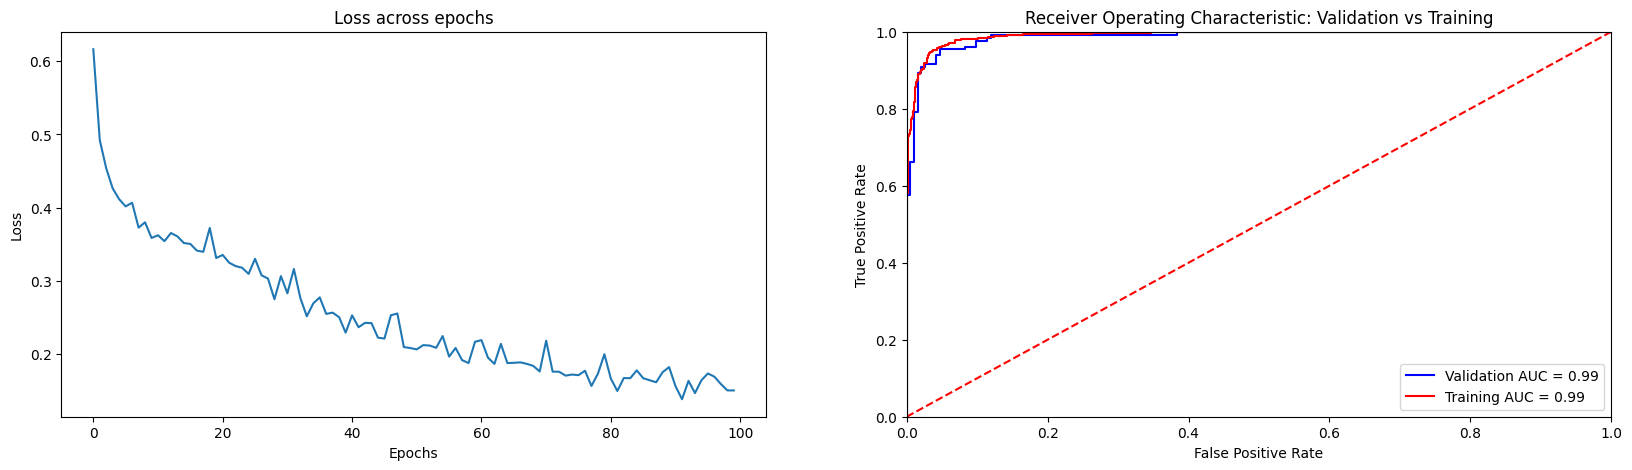

In [14]:
evaluate_model(model = model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_list = net_history["train_loss"])

In [23]:
save_path = "model/pistachio_state_dict"
torch.save(net.state_dict(), save_path)


In [16]:
# for i, (images, labels) in enumerate(val_dataloader):
#     # Get the original file path for the current batch
#     image_path, _ = val_dataset.dataset.samples[val_dataloader.dataset.indices[i]]
#     print(image_path)

In [28]:
import numpy as np
import argparse
import imutils
import cv2

# Load the model
model = Model()
model.load_state_dict(torch.load('model/pistachio_state_dict'))
model.eval()  # Set the model to evaluation mode

idx_to_class = {0: 'kirmizi', 1: 'siirt'}

# Iterate over the validation data
for i, (images, labels) in enumerate(val_dataloader):
    # Get the original file path
    image_path, _ = val_dataset.dataset.samples[val_dataloader.dataset.indices[i]]
    filename = image_path.split('/')[-1]  # Extract the filename from the path

    # Prepare the original image for display
    orig = images[0].permute(1, 2, 0).numpy()  # Original image before transform
    orig = (orig * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # De-normalize
    orig = np.clip(orig * 255.0, 0, 255).astype(np.uint8)
    orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)

    with torch.no_grad():
        outputs = model(images)
        proba = torch.sigmoid(outputs).item() * 100
        label = idx_to_class[proba > 55]  # Classify as 1 if proba > 50%

    # Debugging: print model output and calculated probability
    print(f"Model output: {outputs.cpu().numpy()}")
    print(f"Probability: {proba:.2f}%")
    print(f"Predicted class: {label}, Probability: {proba:.2f}%")

    # Prepare the label to be displayed
    label = f"Label: {label}"
    prob = f"Probability: {proba:.2f}%"

    # Resize the original image for display
    output = imutils.resize(orig, width=600)
    # Put the label and filename on the image
    cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(output, prob, (10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv2.putText(output, "Probability Threshold: 55%", (380, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 100, 0), 1)
    cv2.putText(output, filename, (10, 580), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 100, 0), 1)

    # Display the image with predictiona
    cv2.imshow("Output", output)
    cv2.waitKey(0)  # Wait for key press to show the next image

cv2.destroyAllWindows()

Model output: [[0.01755416]]
Probability: 50.44%
Predicted class: kirmizi, Probability: 50.44%
Model output: [[0.00060212]]
Probability: 50.02%
Predicted class: kirmizi, Probability: 50.02%
Model output: [[0.9914328]]
Probability: 72.94%
Predicted class: siirt, Probability: 72.94%
Model output: [[0.99516714]]
Probability: 73.01%
Predicted class: siirt, Probability: 73.01%
Model output: [[0.00139249]]
Probability: 50.03%
Predicted class: kirmizi, Probability: 50.03%
Model output: [[1.8724569e-06]]
Probability: 50.00%
Predicted class: kirmizi, Probability: 50.00%
Model output: [[0.9859243]]
Probability: 72.83%
Predicted class: siirt, Probability: 72.83%
Model output: [[0.00112303]]
Probability: 50.03%
Predicted class: kirmizi, Probability: 50.03%
Model output: [[1.3507568e-05]]
Probability: 50.00%
Predicted class: kirmizi, Probability: 50.00%
Model output: [[0.01569997]]
Probability: 50.39%
Predicted class: kirmizi, Probability: 50.39%
Model output: [[0.01167393]]
Probability: 50.29%
Pre

KeyboardInterrupt: 